<a href="https://colab.research.google.com/github/mehdihosseinimoghadam/Classification-Of-Skin-Lesions-By-Topological-Data-AnalysisAlongside-With-Neural-Network/blob/main/CNN_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchaudio.transforms as transforms

In [2]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.Conv = nn.Sequential(
        nn.Conv2d(self.in_channels,
                  self.out_channels,
                  4,
                  2,
                  1),
        nn.BatchNorm2d(self.out_channels),
        nn.LeakyReLU()          
    )
  def forward(self, x):
    return self.Conv(x)  



class TransConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TransConvBlock, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.Conv = nn.Sequential(
        nn.ConvTranspose2d(self.in_channels,
                  self.out_channels,
                  4,
                  2,
                  1),
        nn.BatchNorm2d(self.out_channels),
        nn.LeakyReLU()          
    )
  def forward(self, x):
    return self.Conv(x)  






class Encode(nn.Module):
  def __init__(self, in_channels, out_channels, latent_dim, filter_num_list=[2, 4, 8]):
    super(Encode, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.latent_dim = latent_dim
    self.filter_num_list = filter_num_list

    self.Conv = nn.Sequential(
        ConvBlock(self.in_channels, self.out_channels),
        ConvBlock(self.out_channels, self.out_channels * self.filter_num_list[0]),
        ConvBlock(self.out_channels * self.filter_num_list[0], self.out_channels * self.filter_num_list[1]),
        ConvBlock(self.out_channels * self.filter_num_list[1], self.out_channels * self.filter_num_list[2])
    )

    self.fc = nn.Linear(80 * 2 * 2, self.latent_dim)
    self.mu = nn.Linear(self.latent_dim, self.latent_dim)
    self.logvar = nn.Linear(self.latent_dim, self.latent_dim)

  def forward(self, x):
    x = self.Conv(x)
    # print(x.shape)
    x = x.reshape(-1, 80 * 2 * 2)
    x = self.fc(x)
    mu = self.mu(x)
    logvar = self.logvar(x)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels, latent_dim, filter_num_list=[2,4,8]):
    super(Decoder, self).__init__() 
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.latent_dim = latent_dim
    self.filter_num_list = filter_num_list 

    self.DeConve = nn.Sequential(
        TransConvBlock(self.out_channels* self.filter_num_list[2] , self.out_channels * self.filter_num_list[1]),
        TransConvBlock(self.out_channels * self.filter_num_list[1], self.out_channels * self.filter_num_list[0]),
        TransConvBlock(self.out_channels * self.filter_num_list[0], self.out_channels ),
        TransConvBlock(self.out_channels , self.in_channels)
    )
    self.fc = nn.Linear(latent_dim, 1*80*2*2)


  def reparameterezation(self, mu, logvar):
    eps = torch.randn_like(logvar)
    z = mu + eps*torch.exp(.5*logvar) 
    return z


  def forward(self, mu, logvar): 
    z = self.reparameterezation(mu, logvar)
    # print(z.shape)
    z = nn.functional.relu(z)
    # print(z.shape)
    x = nn.functional.relu(self.fc(z))
    # print(x.shape)
    x = x.reshape(-1, 80,2,2)
    x = torch.sigmoid(self.DeConve(x))
    return x, mu, logvar







class VAE(nn.Module):
  def __init__(self, in_channels, out_channels, latent_dim, filter_num_list=[2,4,8]):
    super(VAE, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.latent_dim = latent_dim
    self.filter_num_list = filter_num_list

    self.Encoder = Encode(self.in_channels,  self.out_channels, self.latent_dim)
    self.Decoder = Decoder(self.in_channels, self.out_channels, self.latent_dim)


  def forward(self, x):
    mu, logvar = self.Encoder(x)
    x, mu, logvar = self.Decoder(mu, logvar)
    return x, mu, logvar

In [3]:
a = torch.rand(1,32,32).unsqueeze(0)
En = Encode(in_channels = 1, out_channels = 10, latent_dim = 100)
En(a)[0].shape

torch.Size([1, 100])

In [4]:
b = torch.rand(1,100)
De = Decoder(in_channels = 1, out_channels = 10, latent_dim = 100)
x, mu, logvar = De(b,b)
x.shape

torch.Size([1, 1, 32, 32])

In [5]:
vae = VAE(in_channels = 1, out_channels = 10, latent_dim = 100)
vae(a)

(tensor([[[[0.5353, 0.5221, 0.5249,  ..., 0.5139, 0.5571, 0.5489],
           [0.6607, 0.4978, 0.4995,  ..., 0.4986, 0.5602, 0.4999],
           [0.6003, 0.4973, 0.4996,  ..., 0.5351, 0.5249, 0.5113],
           ...,
           [0.6068, 0.4996, 0.7125,  ..., 0.4976, 0.5506, 0.5649],
           [0.5761, 0.4994, 0.4998,  ..., 0.4993, 0.5452, 0.5309],
           [0.6357, 0.4997, 0.6840,  ..., 0.5708, 0.6490, 0.4999]]]],
        grad_fn=<SigmoidBackward0>),
 tensor([[-2.9520e-01, -3.5885e-02, -9.2215e-02, -3.7514e-01,  2.9697e-02,
          -1.3098e-01,  9.9690e-02,  2.1179e-01, -2.8628e-03,  9.2595e-02,
           4.7750e-02,  5.0028e-02, -1.6188e-01,  4.3983e-01,  5.4336e-02,
           1.9784e-02,  3.2000e-01,  1.1059e-01, -3.8039e-03,  2.9350e-01,
          -5.3559e-02,  3.4590e-02, -5.8531e-02, -4.8365e-02,  1.3147e-01,
           3.1705e-01,  8.6155e-02,  1.3580e-02,  4.1048e-01,  9.4888e-02,
           8.6644e-02,  7.2111e-02, -2.3037e-01, -1.0478e-01, -1.3305e-01,
           2.9435

In [6]:
import torchvision.datasets as Datasets
import torchvision.transforms as transform
from torch.utils.data import DataLoader 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
trans = transform.Compose([
                           transform.ToTensor(),
                           transform.Resize(32)
])

In [8]:
train_data = Datasets.MNIST(root="/", train=True, transform=trans, download=True)
test_data = Datasets.MNIST(root="/", train=False, transform=trans, download=True)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw



## Training

In [10]:
import torch.optim as optim
import torch.nn.functional as F
model = VAE(in_channels = 1, out_channels = 10, latent_dim = 1024).to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 2891287


In [11]:
def VAE_loss(recon_x, x, mu, logvar):
  loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_loss =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return loss + kl_loss  

In [ ]:
num_epochs = 20
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = VAE_loss(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))

Epoch : 1 , Minibatch : 0 Loss = 14884.0566
Epoch : 1 , Minibatch : 100 Loss = 1168443.3594
Epoch : 1 , Minibatch : 200 Loss = 1135774.9463
Epoch : 1 , Minibatch : 300 Loss = 1135600.8574
Epoch : 1 , Minibatch : 400 Loss = 1135500.5225
Epoch : 1 , Minibatch : 500 Loss = 1135432.1914
Epoch : 1 , Minibatch : 600 Loss = 1135353.0713
Epoch : 1 , Minibatch : 700 Loss = 1135305.6758
Epoch : 1 , Minibatch : 800 Loss = 1135193.2715
Epoch : 1 , Minibatch : 900 Loss = 1135094.1934
Epoch : 1 , Minibatch : 1000 Loss = 1135017.1797
Epoch : 1 , Minibatch : 1100 Loss = 1134909.8125
Epoch : 1 , Minibatch : 1200 Loss = 1134781.5771
Epoch : 1 , Minibatch : 1300 Loss = 1134661.3311
Epoch : 1 , Minibatch : 1400 Loss = 1134541.6875
Epoch : 1 , Minibatch : 1500 Loss = 1134420.1240
Epoch : 1 , Minibatch : 1600 Loss = 1134231.8271
Epoch : 1 , Minibatch : 1700 Loss = 1134085.3203
Epoch : 1 , Minibatch : 1800 Loss = 1133911.9023
Epoch : 1 , Minibatch : 1900 Loss = 1133698.4453
Epoch : 1 , Minibatch : 2000 Loss 

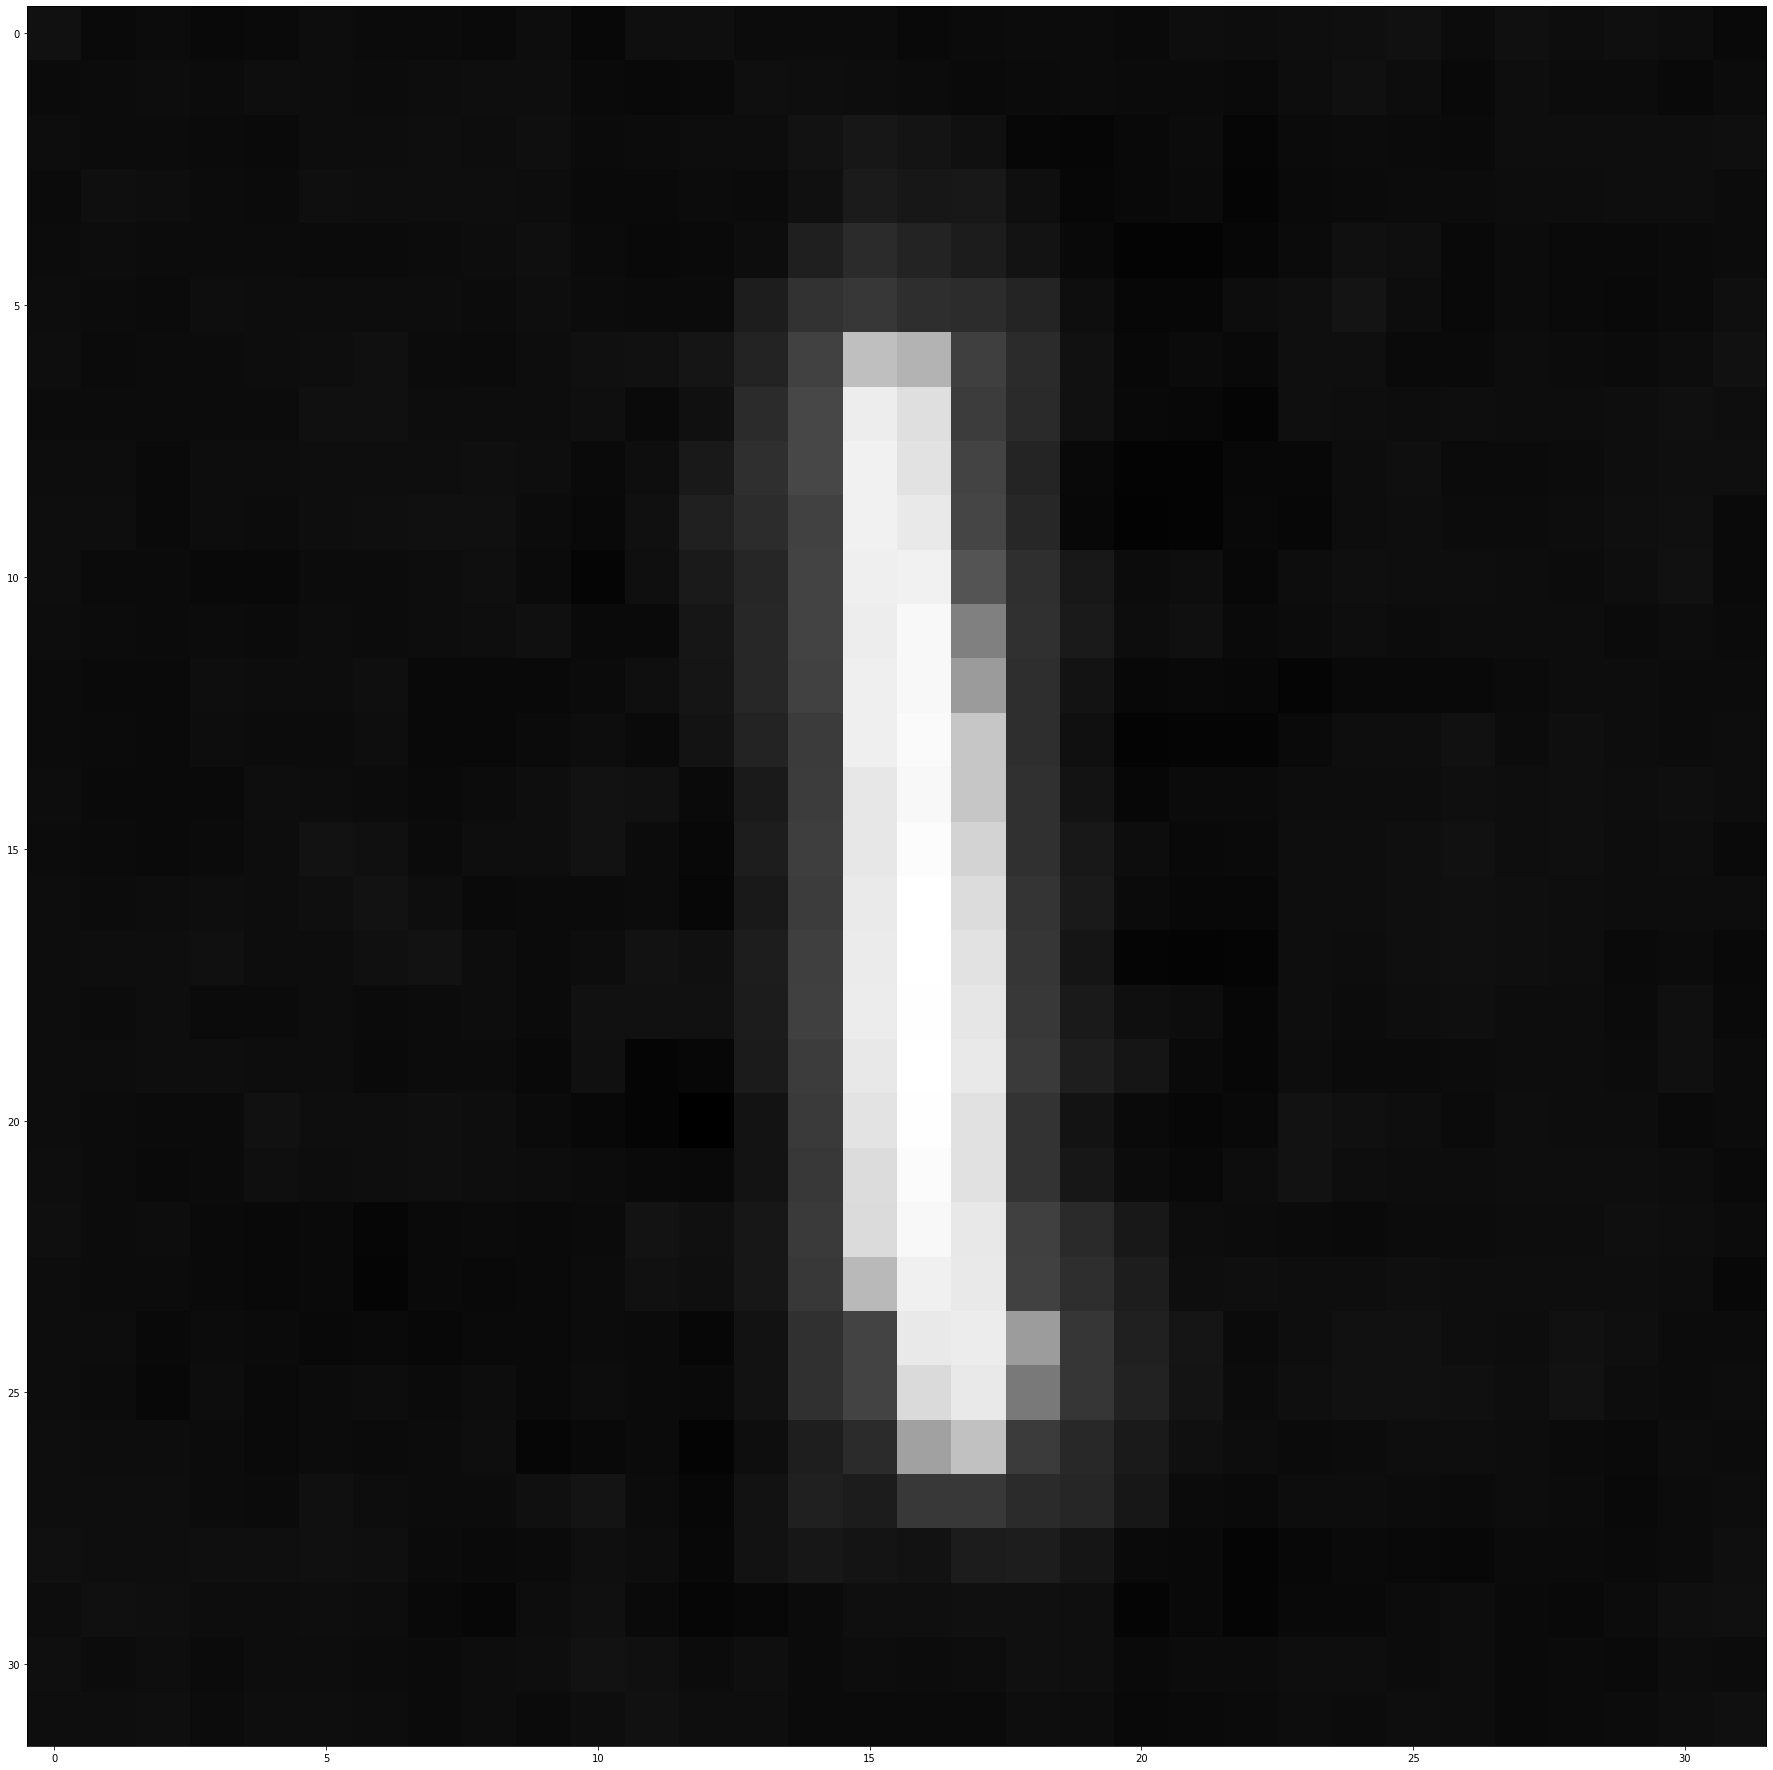

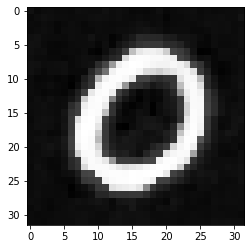

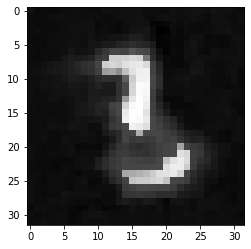

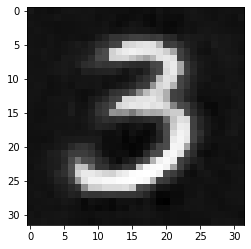

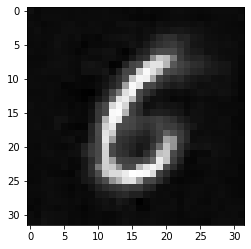

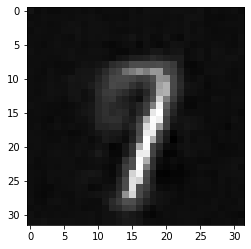

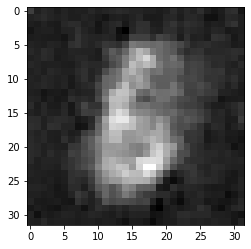

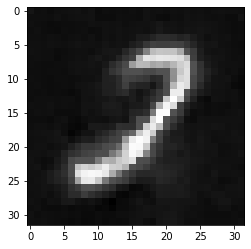

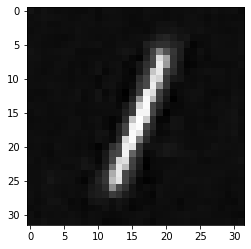

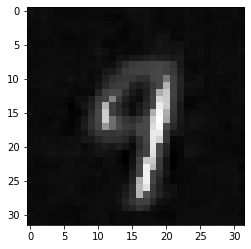

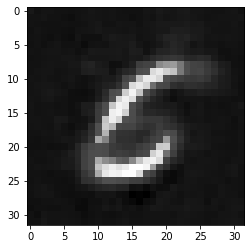

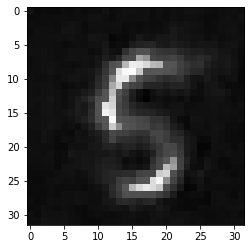

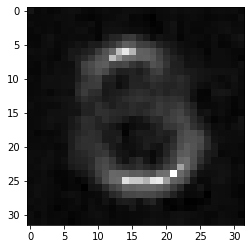

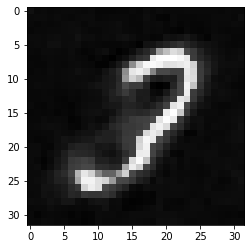

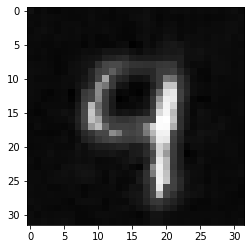

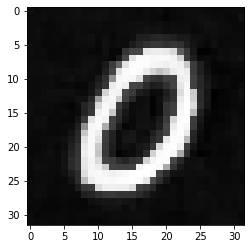

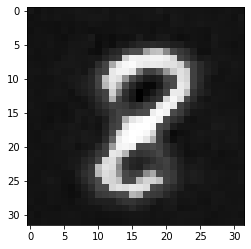

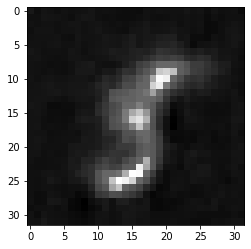

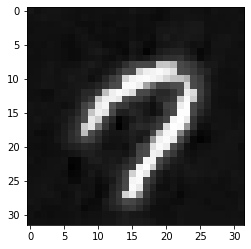

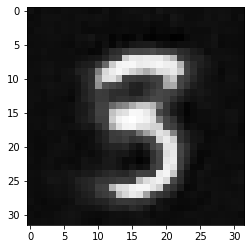

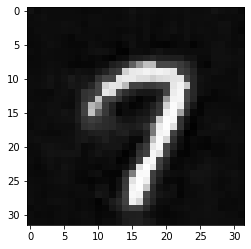

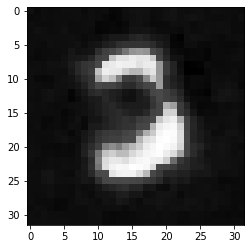

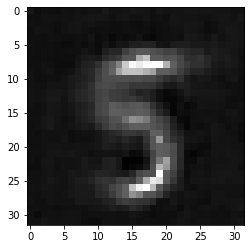

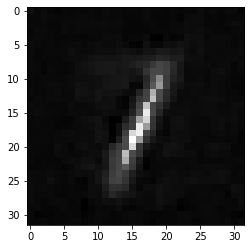

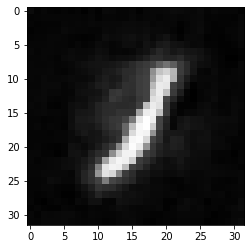

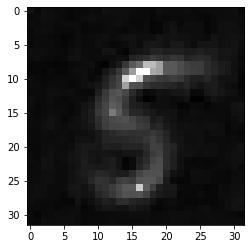

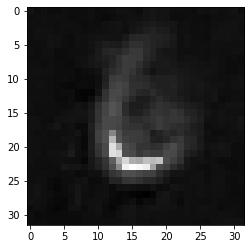

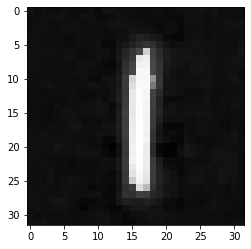

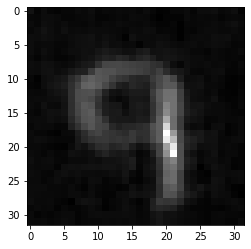

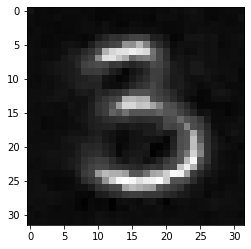

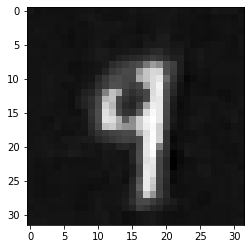

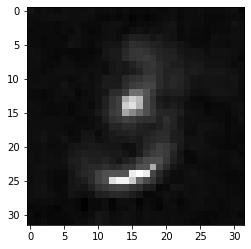

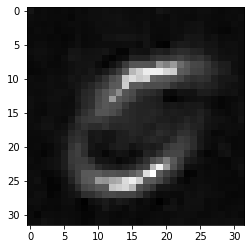

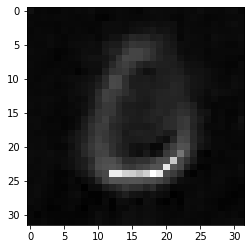

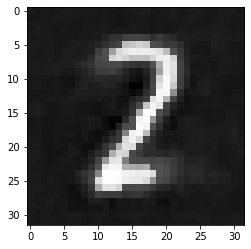

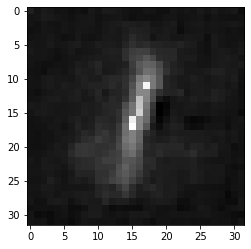

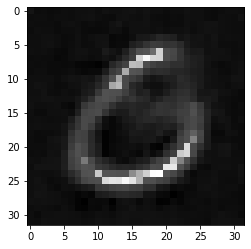

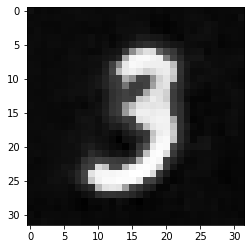

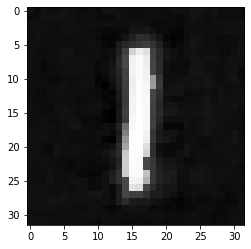

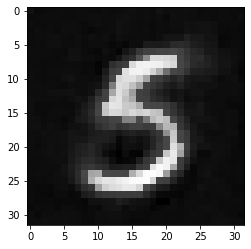

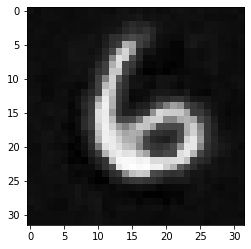

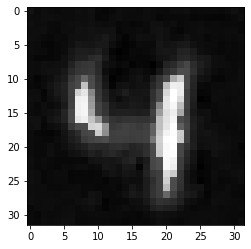

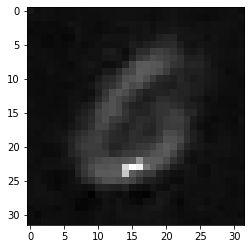

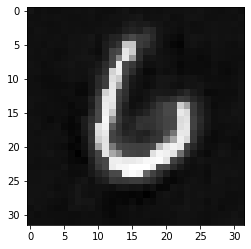

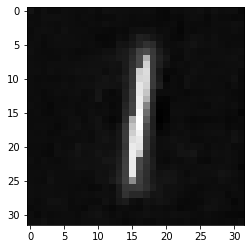

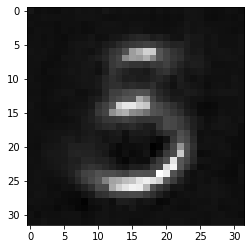

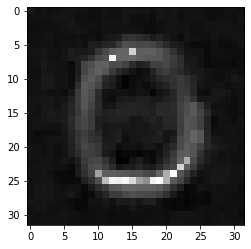

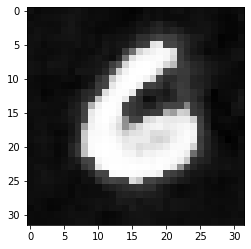

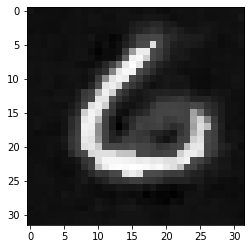

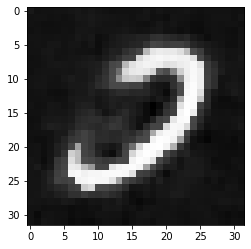

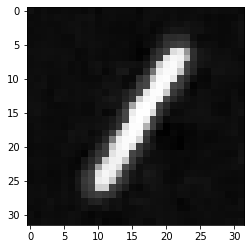

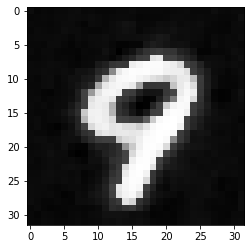

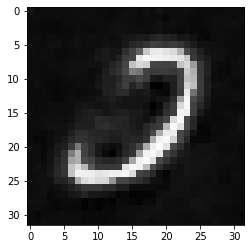

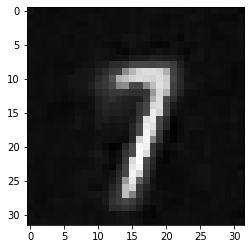

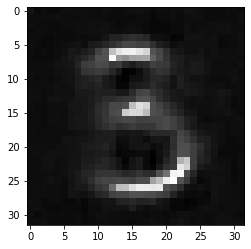

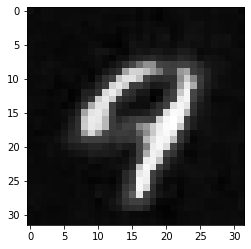

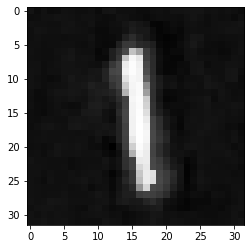

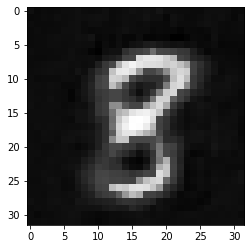

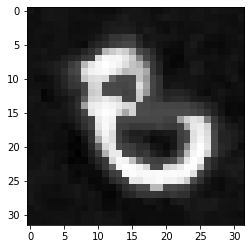

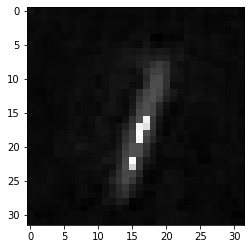

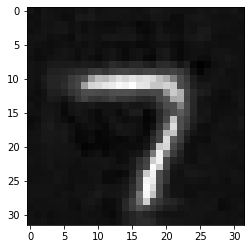

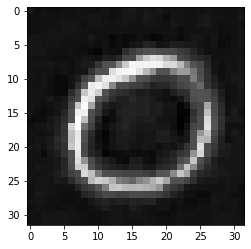

KeyboardInterrupt: ignored

In [60]:
import matplotlib.pyplot as plt
test_loss = 0
print_per = 10
fig=plt.figure(figsize=(32, 32))
columns = 2
rows = 5
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        recon_batch, mu, logvar = model(images)
        test_loss += VAE_loss(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(32, 32), cmap='gray')
            plt.show(block=True)